In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-07 16:42:27.694293: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-07 16:42:27.694331: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.01)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="chisq", threshold=0.5,
                                  noise_distribution="chisq", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:33280, :], y[:33280]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

optimal_schedules = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 3*28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 3*59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 3*1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 3*1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 3*1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 3*2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 3*1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 3*4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in optimal_schedules:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

Epoch 1/119


2022-05-07 16:42:32.127296: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-07 16:42:32.127343: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-07 16:42:32.127376: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-07 16:42:32.127711: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


130/130 [==============================] - 3s 9ms/step - loss: 0.6912 - accuracy: 0.5038 - auc: 0.5681 - val_loss: 0.6837 - val_accuracy: 0.5175 - val_auc: 0.5815
Epoch 2/119
130/130 [==============================] - 1s 4ms/step - loss: 0.6875 - accuracy: 0.5051 - auc: 0.5889 - val_loss: 0.6801 - val_accuracy: 0.5238 - val_auc: 0.6142
Epoch 3/119
130/130 [==============================] - 1s 4ms/step - loss: 0.6847 - accuracy: 0.5087 - auc: 0.6030 - val_loss: 0.6772 - val_accuracy: 0.5288 - val_auc: 0.6424
Epoch 4/119
130/130 [==============================] - 1s 4ms/step - loss: 0.6822 - accuracy: 0.5148 - auc: 0.6154 - val_loss: 0.6747 - val_accuracy: 0.5326 - val_auc: 0.6693
Epoch 5/119
130/130 [==============================] - 1s 4ms/step - loss: 0.6794 - accuracy: 0.5213 - auc: 0.6296 - val_loss: 0.6726 - val_accuracy: 0.5377 - val_auc: 0.6923
Epoch 6/119
130/130 [==============================] - 1s 6ms/step - loss: 0.6770 - accuracy: 0.5189 - auc: 0.6415 - val_loss: 0.6706 - v

Epoch 48/119
130/130 [==============================] - 1s 6ms/step - loss: 0.5282 - accuracy: 0.7586 - auc: 0.8521 - val_loss: 0.4913 - val_accuracy: 0.8759 - val_auc: 0.9562
Epoch 49/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5168 - accuracy: 0.7685 - auc: 0.8623 - val_loss: 0.4834 - val_accuracy: 0.8783 - val_auc: 0.9579
Epoch 50/119
130/130 [==============================] - 1s 6ms/step - loss: 0.5165 - accuracy: 0.7644 - auc: 0.8577 - val_loss: 0.4767 - val_accuracy: 0.8791 - val_auc: 0.9595
Epoch 51/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5077 - accuracy: 0.7715 - auc: 0.8638 - val_loss: 0.4698 - val_accuracy: 0.8796 - val_auc: 0.9611
Epoch 52/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5032 - accuracy: 0.7767 - auc: 0.8653 - val_loss: 0.4636 - val_accuracy: 0.8788 - val_auc: 0.9626
Epoch 53/119
130/130 [==============================] - 1s 5ms/step - loss: 0.4960 - accuracy: 0.7804 - auc: 0.8691 - va

130/130 [==============================] - 1s 5ms/step - loss: 0.3521 - accuracy: 0.8441 - auc: 0.9259 - val_loss: 0.2812 - val_accuracy: 0.8898 - val_auc: 0.9906
Epoch 95/119
130/130 [==============================] - 1s 4ms/step - loss: 0.3507 - accuracy: 0.8432 - auc: 0.9259 - val_loss: 0.2784 - val_accuracy: 0.8913 - val_auc: 0.9908
Epoch 96/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3500 - accuracy: 0.8438 - auc: 0.9262 - val_loss: 0.2752 - val_accuracy: 0.8931 - val_auc: 0.9909
Epoch 97/119
130/130 [==============================] - 0s 4ms/step - loss: 0.3460 - accuracy: 0.8479 - auc: 0.9285 - val_loss: 0.2754 - val_accuracy: 0.8901 - val_auc: 0.9911
Epoch 98/119
130/130 [==============================] - 1s 4ms/step - loss: 0.3436 - accuracy: 0.8459 - auc: 0.9291 - val_loss: 0.2725 - val_accuracy: 0.8910 - val_auc: 0.9912
Epoch 99/119
130/130 [==============================] - 1s 5ms/step - loss: 0.3458 - accuracy: 0.8439 - auc: 0.9277 - val_loss: 0.273

130/130 [==============================] - 0s 3ms/step - loss: 0.5803 - accuracy: 0.7175 - auc: 0.8203 - val_loss: 0.5517 - val_accuracy: 0.8588 - val_auc: 0.9516
Epoch 21/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5730 - accuracy: 0.7248 - auc: 0.8245 - val_loss: 0.5419 - val_accuracy: 0.8654 - val_auc: 0.9543
Epoch 22/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5673 - accuracy: 0.7290 - auc: 0.8270 - val_loss: 0.5320 - val_accuracy: 0.8724 - val_auc: 0.9568
Epoch 23/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5597 - accuracy: 0.7356 - auc: 0.8317 - val_loss: 0.5225 - val_accuracy: 0.8785 - val_auc: 0.9591
Epoch 24/119
130/130 [==============================] - 0s 4ms/step - loss: 0.5497 - accuracy: 0.7448 - auc: 0.8395 - val_loss: 0.5126 - val_accuracy: 0.8854 - val_auc: 0.9610
Epoch 25/119
130/130 [==============================] - 0s 4ms/step - loss: 0.5411 - accuracy: 0.7481 - auc: 0.8425 - val_loss: 0.501

130/130 [==============================] - 1s 6ms/step - loss: 0.3428 - accuracy: 0.8461 - auc: 0.9288 - val_loss: 0.2620 - val_accuracy: 0.9010 - val_auc: 0.9912
Epoch 67/119
130/130 [==============================] - 1s 6ms/step - loss: 0.3444 - accuracy: 0.8446 - auc: 0.9275 - val_loss: 0.2604 - val_accuracy: 0.9007 - val_auc: 0.9913
Epoch 68/119
130/130 [==============================] - 1s 6ms/step - loss: 0.3403 - accuracy: 0.8482 - auc: 0.9294 - val_loss: 0.2592 - val_accuracy: 0.8994 - val_auc: 0.9914
Epoch 69/119
130/130 [==============================] - 1s 7ms/step - loss: 0.3373 - accuracy: 0.8498 - auc: 0.9308 - val_loss: 0.2564 - val_accuracy: 0.9010 - val_auc: 0.9915
Epoch 70/119
130/130 [==============================] - 1s 7ms/step - loss: 0.3360 - accuracy: 0.8486 - auc: 0.9311 - val_loss: 0.2573 - val_accuracy: 0.8976 - val_auc: 0.9916
Epoch 71/119
130/130 [==============================] - 1s 7ms/step - loss: 0.3360 - accuracy: 0.8489 - auc: 0.9309 - val_loss: 0.255

130/130 [==============================] - 1s 7ms/step - loss: 0.2897 - accuracy: 0.8685 - auc: 0.9485 - val_loss: 0.2508 - val_accuracy: 0.8726 - val_auc: 0.9936
Epoch 113/119
130/130 [==============================] - 1s 7ms/step - loss: 0.2860 - accuracy: 0.8736 - auc: 0.9499 - val_loss: 0.2504 - val_accuracy: 0.8726 - val_auc: 0.9936
Epoch 114/119
130/130 [==============================] - 1s 7ms/step - loss: 0.2901 - accuracy: 0.8699 - auc: 0.9484 - val_loss: 0.2503 - val_accuracy: 0.8727 - val_auc: 0.9936
Epoch 115/119
130/130 [==============================] - 1s 8ms/step - loss: 0.2856 - accuracy: 0.8731 - auc: 0.9501 - val_loss: 0.2524 - val_accuracy: 0.8710 - val_auc: 0.9936
Epoch 116/119
130/130 [==============================] - 1s 8ms/step - loss: 0.2837 - accuracy: 0.8739 - auc: 0.9506 - val_loss: 0.2557 - val_accuracy: 0.8690 - val_auc: 0.9936
Epoch 117/119
130/130 [==============================] - 1s 7ms/step - loss: 0.2862 - accuracy: 0.8717 - auc: 0.9495 - val_loss: 

130/130 [==============================] - 1s 6ms/step - loss: 0.3912 - accuracy: 0.8244 - auc: 0.9105 - val_loss: 0.3036 - val_accuracy: 0.9156 - val_auc: 0.9859
Epoch 39/119
130/130 [==============================] - 1s 6ms/step - loss: 0.3839 - accuracy: 0.8283 - auc: 0.9135 - val_loss: 0.2973 - val_accuracy: 0.9150 - val_auc: 0.9866
Epoch 40/119
130/130 [==============================] - 1s 8ms/step - loss: 0.3790 - accuracy: 0.8304 - auc: 0.9153 - val_loss: 0.2911 - val_accuracy: 0.9153 - val_auc: 0.9872
Epoch 41/119
130/130 [==============================] - 1s 6ms/step - loss: 0.3760 - accuracy: 0.8291 - auc: 0.9163 - val_loss: 0.2841 - val_accuracy: 0.9173 - val_auc: 0.9877
Epoch 42/119
130/130 [==============================] - 1s 8ms/step - loss: 0.3714 - accuracy: 0.8329 - auc: 0.9177 - val_loss: 0.2816 - val_accuracy: 0.9137 - val_auc: 0.9883
Epoch 43/119
130/130 [==============================] - 1s 7ms/step - loss: 0.3674 - accuracy: 0.8357 - auc: 0.9193 - val_loss: 0.279

130/130 [==============================] - 1s 5ms/step - loss: 0.2886 - accuracy: 0.8711 - auc: 0.9491 - val_loss: 0.2351 - val_accuracy: 0.8866 - val_auc: 0.9937
Epoch 85/119
130/130 [==============================] - 1s 6ms/step - loss: 0.2845 - accuracy: 0.8721 - auc: 0.9508 - val_loss: 0.2401 - val_accuracy: 0.8813 - val_auc: 0.9936
Epoch 86/119
130/130 [==============================] - 1s 5ms/step - loss: 0.2845 - accuracy: 0.8720 - auc: 0.9505 - val_loss: 0.2355 - val_accuracy: 0.8853 - val_auc: 0.9937
Epoch 87/119
130/130 [==============================] - 1s 5ms/step - loss: 0.2819 - accuracy: 0.8750 - auc: 0.9516 - val_loss: 0.2330 - val_accuracy: 0.8870 - val_auc: 0.9937
Epoch 88/119
130/130 [==============================] - 1s 5ms/step - loss: 0.2832 - accuracy: 0.8740 - auc: 0.9511 - val_loss: 0.2360 - val_accuracy: 0.8843 - val_auc: 0.9937
Epoch 89/119
130/130 [==============================] - 1s 5ms/step - loss: 0.2815 - accuracy: 0.8759 - auc: 0.9516 - val_loss: 0.242

130/130 [==============================] - 1s 5ms/step - loss: 0.6663 - accuracy: 0.5786 - auc: 0.6568 - val_loss: 0.6566 - val_accuracy: 0.6429 - val_auc: 0.7755
Epoch 11/249
130/130 [==============================] - 1s 6ms/step - loss: 0.6619 - accuracy: 0.5911 - auc: 0.6724 - val_loss: 0.6535 - val_accuracy: 0.6574 - val_auc: 0.7868
Epoch 12/249
130/130 [==============================] - 1s 5ms/step - loss: 0.6595 - accuracy: 0.5990 - auc: 0.6785 - val_loss: 0.6505 - val_accuracy: 0.6737 - val_auc: 0.7972
Epoch 13/249
130/130 [==============================] - 1s 6ms/step - loss: 0.6558 - accuracy: 0.6082 - auc: 0.6913 - val_loss: 0.6474 - val_accuracy: 0.6873 - val_auc: 0.8061
Epoch 14/249
130/130 [==============================] - 1s 5ms/step - loss: 0.6531 - accuracy: 0.6173 - auc: 0.6974 - val_loss: 0.6443 - val_accuracy: 0.7021 - val_auc: 0.8148
Epoch 15/249
130/130 [==============================] - 1s 6ms/step - loss: 0.6514 - accuracy: 0.6221 - auc: 0.7015 - val_loss: 0.641

130/130 [==============================] - 1s 5ms/step - loss: 0.4931 - accuracy: 0.7745 - auc: 0.8645 - val_loss: 0.4463 - val_accuracy: 0.8802 - val_auc: 0.9667
Epoch 57/249
130/130 [==============================] - 1s 6ms/step - loss: 0.4856 - accuracy: 0.7820 - auc: 0.8698 - val_loss: 0.4410 - val_accuracy: 0.8811 - val_auc: 0.9677
Epoch 58/249
130/130 [==============================] - 1s 5ms/step - loss: 0.4817 - accuracy: 0.7849 - auc: 0.8716 - val_loss: 0.4354 - val_accuracy: 0.8824 - val_auc: 0.9689
Epoch 59/249
130/130 [==============================] - 1s 5ms/step - loss: 0.4807 - accuracy: 0.7814 - auc: 0.8712 - val_loss: 0.4306 - val_accuracy: 0.8821 - val_auc: 0.9699
Epoch 60/249
130/130 [==============================] - 1s 6ms/step - loss: 0.4775 - accuracy: 0.7869 - auc: 0.8727 - val_loss: 0.4255 - val_accuracy: 0.8828 - val_auc: 0.9710
Epoch 61/249
130/130 [==============================] - 1s 6ms/step - loss: 0.4728 - accuracy: 0.7867 - auc: 0.8749 - val_loss: 0.419

130/130 [==============================] - 1s 5ms/step - loss: 0.3544 - accuracy: 0.8420 - auc: 0.9262 - val_loss: 0.2635 - val_accuracy: 0.9142 - val_auc: 0.9920
Epoch 103/249
130/130 [==============================] - 1s 5ms/step - loss: 0.3510 - accuracy: 0.8442 - auc: 0.9287 - val_loss: 0.2621 - val_accuracy: 0.9140 - val_auc: 0.9921
Epoch 104/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3514 - accuracy: 0.8427 - auc: 0.9279 - val_loss: 0.2595 - val_accuracy: 0.9144 - val_auc: 0.9922
Epoch 105/249
130/130 [==============================] - 1s 6ms/step - loss: 0.3473 - accuracy: 0.8464 - auc: 0.9292 - val_loss: 0.2581 - val_accuracy: 0.9136 - val_auc: 0.9922
Epoch 106/249
130/130 [==============================] - 1s 6ms/step - loss: 0.3463 - accuracy: 0.8446 - auc: 0.9297 - val_loss: 0.2576 - val_accuracy: 0.9128 - val_auc: 0.9922
Epoch 107/249
130/130 [==============================] - 1s 6ms/step - loss: 0.3485 - accuracy: 0.8444 - auc: 0.9286 - val_loss: 

130/130 [==============================] - 1s 5ms/step - loss: 0.3075 - accuracy: 0.8627 - auc: 0.9436 - val_loss: 0.2206 - val_accuracy: 0.9115 - val_auc: 0.9936
Epoch 149/249
130/130 [==============================] - 1s 6ms/step - loss: 0.3066 - accuracy: 0.8666 - auc: 0.9441 - val_loss: 0.2218 - val_accuracy: 0.9096 - val_auc: 0.9936
Epoch 150/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3052 - accuracy: 0.8659 - auc: 0.9448 - val_loss: 0.2164 - val_accuracy: 0.9149 - val_auc: 0.9937
Epoch 151/249
130/130 [==============================] - 1s 6ms/step - loss: 0.3034 - accuracy: 0.8643 - auc: 0.9457 - val_loss: 0.2186 - val_accuracy: 0.9123 - val_auc: 0.9938
Epoch 152/249
130/130 [==============================] - 1s 6ms/step - loss: 0.3018 - accuracy: 0.8656 - auc: 0.9460 - val_loss: 0.2180 - val_accuracy: 0.9123 - val_auc: 0.9938
Epoch 153/249
130/130 [==============================] - 1s 5ms/step - loss: 0.3014 - accuracy: 0.8672 - auc: 0.9463 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.2790 - accuracy: 0.8769 - auc: 0.9535 - val_loss: 0.2105 - val_accuracy: 0.9068 - val_auc: 0.9946
Epoch 195/249
130/130 [==============================] - 1s 6ms/step - loss: 0.2814 - accuracy: 0.8774 - auc: 0.9529 - val_loss: 0.2137 - val_accuracy: 0.9035 - val_auc: 0.9946
Epoch 196/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2785 - accuracy: 0.8784 - auc: 0.9539 - val_loss: 0.2150 - val_accuracy: 0.9018 - val_auc: 0.9947
Epoch 197/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2774 - accuracy: 0.8779 - auc: 0.9543 - val_loss: 0.2094 - val_accuracy: 0.9066 - val_auc: 0.9947
Epoch 198/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2838 - accuracy: 0.8749 - auc: 0.9519 - val_loss: 0.2130 - val_accuracy: 0.9031 - val_auc: 0.9948
Epoch 199/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2773 - accuracy: 0.8806 - auc: 0.9542 - val_loss: 

130/130 [==============================] - 1s 5ms/step - loss: 0.2619 - accuracy: 0.8869 - auc: 0.9589 - val_loss: 0.2105 - val_accuracy: 0.9001 - val_auc: 0.9955
Epoch 241/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2612 - accuracy: 0.8862 - auc: 0.9590 - val_loss: 0.2084 - val_accuracy: 0.9020 - val_auc: 0.9955
Epoch 242/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2598 - accuracy: 0.8865 - auc: 0.9598 - val_loss: 0.2073 - val_accuracy: 0.9025 - val_auc: 0.9955
Epoch 243/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2646 - accuracy: 0.8847 - auc: 0.9582 - val_loss: 0.2139 - val_accuracy: 0.8974 - val_auc: 0.9954
Epoch 244/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2617 - accuracy: 0.8864 - auc: 0.9589 - val_loss: 0.2169 - val_accuracy: 0.8948 - val_auc: 0.9954
Epoch 245/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2622 - accuracy: 0.8848 - auc: 0.9587 - val_loss: 

130/130 [==============================] - 1s 5ms/step - loss: 0.5420 - accuracy: 0.7484 - auc: 0.8339 - val_loss: 0.5091 - val_accuracy: 0.8523 - val_auc: 0.9380
Epoch 37/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5389 - accuracy: 0.7507 - auc: 0.8350 - val_loss: 0.5026 - val_accuracy: 0.8553 - val_auc: 0.9409
Epoch 38/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5341 - accuracy: 0.7523 - auc: 0.8373 - val_loss: 0.4958 - val_accuracy: 0.8576 - val_auc: 0.9435
Epoch 39/249
130/130 [==============================] - 1s 5ms/step - loss: 0.5263 - accuracy: 0.7575 - auc: 0.8448 - val_loss: 0.4892 - val_accuracy: 0.8598 - val_auc: 0.9462
Epoch 40/249
130/130 [==============================] - 1s 5ms/step - loss: 0.5232 - accuracy: 0.7602 - auc: 0.8453 - val_loss: 0.4827 - val_accuracy: 0.8618 - val_auc: 0.9485
Epoch 41/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5157 - accuracy: 0.7649 - auc: 0.8515 - val_loss: 0.474

130/130 [==============================] - 1s 6ms/step - loss: 0.3526 - accuracy: 0.8441 - auc: 0.9290 - val_loss: 0.2663 - val_accuracy: 0.9121 - val_auc: 0.9926
Epoch 83/249
130/130 [==============================] - 1s 6ms/step - loss: 0.3515 - accuracy: 0.8434 - auc: 0.9291 - val_loss: 0.2619 - val_accuracy: 0.9150 - val_auc: 0.9928
Epoch 84/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3481 - accuracy: 0.8446 - auc: 0.9302 - val_loss: 0.2607 - val_accuracy: 0.9132 - val_auc: 0.9929
Epoch 85/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3459 - accuracy: 0.8458 - auc: 0.9317 - val_loss: 0.2574 - val_accuracy: 0.9147 - val_auc: 0.9930
Epoch 86/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3446 - accuracy: 0.8483 - auc: 0.9317 - val_loss: 0.2534 - val_accuracy: 0.9183 - val_auc: 0.9932
Epoch 87/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3454 - accuracy: 0.8465 - auc: 0.9311 - val_loss: 0.255

130/130 [==============================] - 1s 4ms/step - loss: 0.2991 - accuracy: 0.8684 - auc: 0.9476 - val_loss: 0.2240 - val_accuracy: 0.9026 - val_auc: 0.9943
Epoch 129/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2982 - accuracy: 0.8683 - auc: 0.9477 - val_loss: 0.2257 - val_accuracy: 0.9007 - val_auc: 0.9945
Epoch 130/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2980 - accuracy: 0.8701 - auc: 0.9481 - val_loss: 0.2200 - val_accuracy: 0.9057 - val_auc: 0.9945
Epoch 131/249
130/130 [==============================] - 1s 6ms/step - loss: 0.2956 - accuracy: 0.8697 - auc: 0.9484 - val_loss: 0.2208 - val_accuracy: 0.9043 - val_auc: 0.9945
Epoch 132/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2944 - accuracy: 0.8719 - auc: 0.9494 - val_loss: 0.2224 - val_accuracy: 0.9018 - val_auc: 0.9946
Epoch 133/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2929 - accuracy: 0.8712 - auc: 0.9495 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.2682 - accuracy: 0.8828 - auc: 0.9571 - val_loss: 0.2197 - val_accuracy: 0.8942 - val_auc: 0.9953
Epoch 175/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2714 - accuracy: 0.8834 - auc: 0.9565 - val_loss: 0.2196 - val_accuracy: 0.8939 - val_auc: 0.9954
Epoch 176/249
130/130 [==============================] - 1s 6ms/step - loss: 0.2692 - accuracy: 0.8812 - auc: 0.9571 - val_loss: 0.2200 - val_accuracy: 0.8939 - val_auc: 0.9954
Epoch 177/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2701 - accuracy: 0.8825 - auc: 0.9567 - val_loss: 0.2214 - val_accuracy: 0.8931 - val_auc: 0.9954
Epoch 178/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2727 - accuracy: 0.8803 - auc: 0.9559 - val_loss: 0.2135 - val_accuracy: 0.8985 - val_auc: 0.9954
Epoch 179/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2696 - accuracy: 0.8836 - auc: 0.9568 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.2510 - accuracy: 0.8919 - auc: 0.9623 - val_loss: 0.2275 - val_accuracy: 0.8846 - val_auc: 0.9958
Epoch 221/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2512 - accuracy: 0.8911 - auc: 0.9622 - val_loss: 0.2231 - val_accuracy: 0.8871 - val_auc: 0.9958
Epoch 222/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2530 - accuracy: 0.8902 - auc: 0.9618 - val_loss: 0.2190 - val_accuracy: 0.8906 - val_auc: 0.9959
Epoch 223/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2502 - accuracy: 0.8927 - auc: 0.9625 - val_loss: 0.2365 - val_accuracy: 0.8773 - val_auc: 0.9958
Epoch 224/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2544 - accuracy: 0.8927 - auc: 0.9613 - val_loss: 0.2212 - val_accuracy: 0.8888 - val_auc: 0.9958
Epoch 225/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2509 - accuracy: 0.8917 - auc: 0.9625 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.6086 - accuracy: 0.7014 - auc: 0.7873 - val_loss: 0.5994 - val_accuracy: 0.8163 - val_auc: 0.9043
Epoch 17/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6041 - accuracy: 0.7011 - auc: 0.7891 - val_loss: 0.5937 - val_accuracy: 0.8196 - val_auc: 0.9100
Epoch 18/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5976 - accuracy: 0.7115 - auc: 0.7967 - val_loss: 0.5870 - val_accuracy: 0.8235 - val_auc: 0.9148
Epoch 19/249
130/130 [==============================] - 1s 6ms/step - loss: 0.5908 - accuracy: 0.7152 - auc: 0.8031 - val_loss: 0.5801 - val_accuracy: 0.8280 - val_auc: 0.9199
Epoch 20/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5855 - accuracy: 0.7209 - auc: 0.8089 - val_loss: 0.5731 - val_accuracy: 0.8315 - val_auc: 0.9244
Epoch 21/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5800 - accuracy: 0.7269 - auc: 0.8132 - val_loss: 0.566

130/130 [==============================] - 1s 4ms/step - loss: 0.3634 - accuracy: 0.8371 - auc: 0.9235 - val_loss: 0.2888 - val_accuracy: 0.9002 - val_auc: 0.9908
Epoch 63/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3606 - accuracy: 0.8403 - auc: 0.9249 - val_loss: 0.2828 - val_accuracy: 0.9036 - val_auc: 0.9910
Epoch 64/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3565 - accuracy: 0.8428 - auc: 0.9268 - val_loss: 0.2789 - val_accuracy: 0.9050 - val_auc: 0.9911
Epoch 65/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3573 - accuracy: 0.8404 - auc: 0.9257 - val_loss: 0.2755 - val_accuracy: 0.9055 - val_auc: 0.9912
Epoch 66/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3535 - accuracy: 0.8438 - auc: 0.9268 - val_loss: 0.2730 - val_accuracy: 0.9054 - val_auc: 0.9913
Epoch 67/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3511 - accuracy: 0.8425 - auc: 0.9282 - val_loss: 0.271

130/130 [==============================] - 1s 5ms/step - loss: 0.2920 - accuracy: 0.8730 - auc: 0.9495 - val_loss: 0.2207 - val_accuracy: 0.9043 - val_auc: 0.9939
Epoch 109/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2879 - accuracy: 0.8743 - auc: 0.9512 - val_loss: 0.2273 - val_accuracy: 0.8992 - val_auc: 0.9940
Epoch 110/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2964 - accuracy: 0.8698 - auc: 0.9480 - val_loss: 0.2285 - val_accuracy: 0.8979 - val_auc: 0.9940
Epoch 111/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2890 - accuracy: 0.8732 - auc: 0.9507 - val_loss: 0.2256 - val_accuracy: 0.9000 - val_auc: 0.9941
Epoch 112/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2885 - accuracy: 0.8732 - auc: 0.9508 - val_loss: 0.2189 - val_accuracy: 0.9050 - val_auc: 0.9942
Epoch 113/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2871 - accuracy: 0.8745 - auc: 0.9510 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.2614 - accuracy: 0.8869 - auc: 0.9593 - val_loss: 0.2253 - val_accuracy: 0.8899 - val_auc: 0.9955
Epoch 155/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2568 - accuracy: 0.8915 - auc: 0.9606 - val_loss: 0.2239 - val_accuracy: 0.8902 - val_auc: 0.9955
Epoch 156/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2609 - accuracy: 0.8875 - auc: 0.9595 - val_loss: 0.2158 - val_accuracy: 0.8960 - val_auc: 0.9955
Epoch 157/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2613 - accuracy: 0.8860 - auc: 0.9588 - val_loss: 0.2225 - val_accuracy: 0.8911 - val_auc: 0.9955
Epoch 158/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2647 - accuracy: 0.8839 - auc: 0.9578 - val_loss: 0.2221 - val_accuracy: 0.8915 - val_auc: 0.9955
Epoch 159/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2566 - accuracy: 0.8877 - auc: 0.9608 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.2467 - accuracy: 0.8936 - auc: 0.9629 - val_loss: 0.2296 - val_accuracy: 0.8825 - val_auc: 0.9959
Epoch 201/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2424 - accuracy: 0.8970 - auc: 0.9645 - val_loss: 0.2322 - val_accuracy: 0.8818 - val_auc: 0.9959
Epoch 202/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2446 - accuracy: 0.8933 - auc: 0.9637 - val_loss: 0.2322 - val_accuracy: 0.8819 - val_auc: 0.9958
Epoch 203/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2406 - accuracy: 0.8966 - auc: 0.9653 - val_loss: 0.2302 - val_accuracy: 0.8828 - val_auc: 0.9959
Epoch 204/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2440 - accuracy: 0.8955 - auc: 0.9638 - val_loss: 0.2346 - val_accuracy: 0.8803 - val_auc: 0.9959
Epoch 205/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2428 - accuracy: 0.8953 - auc: 0.9645 - val_loss: 

130/130 [==============================] - 1s 6ms/step - loss: 0.2306 - accuracy: 0.9002 - auc: 0.9676 - val_loss: 0.2501 - val_accuracy: 0.8704 - val_auc: 0.9957
Epoch 247/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2344 - accuracy: 0.8983 - auc: 0.9666 - val_loss: 0.2580 - val_accuracy: 0.8663 - val_auc: 0.9957
Epoch 248/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2322 - accuracy: 0.9005 - auc: 0.9670 - val_loss: 0.2524 - val_accuracy: 0.8684 - val_auc: 0.9958
Epoch 249/249
130/130 [==============================] - 0s 4ms/step - loss: 0.2315 - accuracy: 0.8996 - auc: 0.9674 - val_loss: 0.2457 - val_accuracy: 0.8724 - val_auc: 0.9958
{'learning_rate': 0.006, 'batch': 256, 'epoch': 177, 'optimizer': 'sgd', 'best_loss': {'loss': 0.21445207297801971, 'epoch': 134}, 'best_auc': {'auc': 0.9960097074508667, 'epoch': 213}, 'best_accuracy': {'accuracy': 0.9092000126838684, 'epoch': 72}}
Epoch 1/6
4160/4160 [==============================] - 1

4160/4160 [==============================] - 15s 4ms/step - loss: 0.3223 - accuracy: 0.8717 - auc: 0.9373 - val_loss: 0.1830 - val_accuracy: 0.9286 - val_auc: 0.9848
Epoch 6/6
4160/4160 [==============================] - 1093s 263ms/step - loss: 0.3272 - accuracy: 0.8678 - auc: 0.9349 - val_loss: 0.1940 - val_accuracy: 0.9163 - val_auc: 0.9781
{'learning_rate': 0.006, 'batch': 8, 'epoch': 3, 'optimizer': 'rmsprop', 'best_loss': {'loss': 0.18300646543502808, 'epoch': 5}, 'best_auc': {'auc': 0.9848227500915527, 'epoch': 5}, 'best_accuracy': {'accuracy': 0.928600013256073, 'epoch': 5}}
Epoch 1/6
4160/4160 [==============================] - 18s 4ms/step - loss: 0.3647 - accuracy: 0.8257 - auc: 0.9160 - val_loss: 0.2247 - val_accuracy: 0.9047 - val_auc: 0.9818
Epoch 2/6
4160/4160 [==============================] - 17s 4ms/step - loss: 0.2865 - accuracy: 0.8733 - auc: 0.9492 - val_loss: 0.2356 - val_accuracy: 0.8910 - val_auc: 0.9769
Epoch 3/6
4160/4160 [==============================] - 15s

4160/4160 [==============================] - 16s 4ms/step - loss: 0.2913 - accuracy: 0.8696 - auc: 0.9485 - val_loss: 0.2541 - val_accuracy: 0.8698 - val_auc: 0.9935
{'learning_rate': 0.1, 'batch': 8, 'epoch': 6, 'optimizer': 'adadelta', 'best_loss': {'loss': 0.24155902862548828, 'epoch': 9}, 'best_auc': {'auc': 0.9935032725334167, 'epoch': 10}, 'best_accuracy': {'accuracy': 0.9014000296592712, 'epoch': 5}}
Epoch 1/10
4160/4160 [==============================] - 18s 4ms/step - loss: 0.6466 - accuracy: 0.6029 - auc: 0.7153 - val_loss: 0.5633 - val_accuracy: 0.8217 - val_auc: 0.9169
Epoch 2/10
4160/4160 [==============================] - 17s 4ms/step - loss: 0.5110 - accuracy: 0.7608 - auc: 0.8476 - val_loss: 0.4019 - val_accuracy: 0.8472 - val_auc: 0.9677
Epoch 3/10
4160/4160 [==============================] - 16s 4ms/step - loss: 0.4088 - accuracy: 0.8110 - auc: 0.8988 - val_loss: 0.3094 - val_accuracy: 0.8753 - val_auc: 0.9848
Epoch 4/10
4160/4160 [==============================] - 12

4160/4160 [==============================] - 18s 4ms/step - loss: 0.2793 - accuracy: 0.8798 - auc: 0.9530 - val_loss: 0.2001 - val_accuracy: 0.9115 - val_auc: 0.9835
Epoch 12/18
4160/4160 [==============================] - 18s 4ms/step - loss: 0.2800 - accuracy: 0.8792 - auc: 0.9522 - val_loss: 0.2220 - val_accuracy: 0.9007 - val_auc: 0.9855
Epoch 13/18
4160/4160 [==============================] - 18s 4ms/step - loss: 0.2751 - accuracy: 0.8816 - auc: 0.9540 - val_loss: 0.2277 - val_accuracy: 0.8926 - val_auc: 0.9832
Epoch 14/18
4160/4160 [==============================] - 18s 4ms/step - loss: 0.2716 - accuracy: 0.8838 - auc: 0.9555 - val_loss: 0.2138 - val_accuracy: 0.9028 - val_auc: 0.9818
Epoch 15/18
4160/4160 [==============================] - 18s 4ms/step - loss: 0.2748 - accuracy: 0.8827 - auc: 0.9541 - val_loss: 0.1859 - val_accuracy: 0.9130 - val_auc: 0.9862
Epoch 16/18
4160/4160 [==============================] - 18s 4ms/step - loss: 0.2721 - accuracy: 0.8828 - auc: 0.9550 - va

4160/4160 [==============================] - 18s 4ms/step - loss: 0.3009 - accuracy: 0.8720 - auc: 0.9464 - val_loss: 0.2895 - val_accuracy: 0.8576 - val_auc: 0.9798
{'learning_rate': 0.0084, 'batch': 8, 'epoch': 12, 'optimizer': 'nadam', 'best_loss': {'loss': 0.199379101395607, 'epoch': 14}, 'best_auc': {'auc': 0.9823000431060791, 'epoch': 16}, 'best_accuracy': {'accuracy': 0.9237499833106995, 'epoch': 8}}


In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/5
4160/4160 [==============================] - 19s 4ms/step - loss: 0.3804 - accuracy: 0.8241 - auc: 0.9102 - val_loss: 0.2407 - val_accuracy: 0.8996 - val_auc: 0.9700
Epoch 2/5
4160/4160 [==============================] - 17s 4ms/step - loss: 0.3309 - accuracy: 0.8586 - auc: 0.9346 - val_loss: 0.2028 - val_accuracy: 0.9221 - val_auc: 0.9811
Epoch 3/5
4160/4160 [==============================] - 17s 4ms/step - loss: 0.3223 - accuracy: 0.8654 - auc: 0.9366 - val_loss: 0.2409 - val_accuracy: 0.8949 - val_auc: 0.9697
Epoch 4/5
4160/4160 [==============================] - 17s 4ms/step - loss: 0.3235 - accuracy: 0.8681 - auc: 0.9359 - val_loss: 0.2021 - val_accuracy: 0.9213 - val_auc: 0.9812
Epoch 5/5
4160/4160 [==============================] - 17s 4ms/step - loss: 0.3277 - accuracy: 0.8669 - auc: 0.9329 - val_loss: 0.1785 - val_accuracy: 0.9283 - val_auc: 0.9817


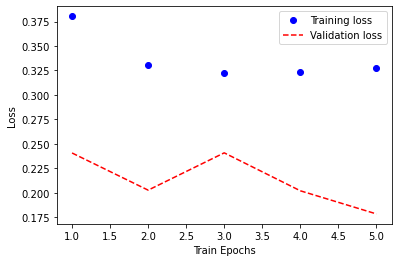

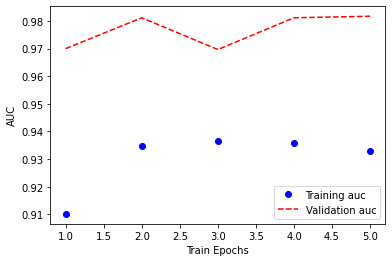

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

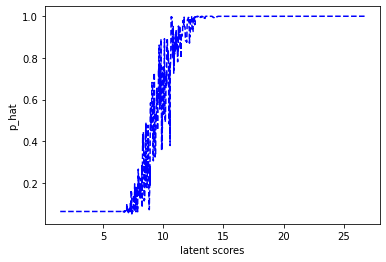

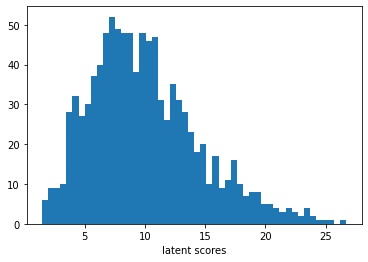

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

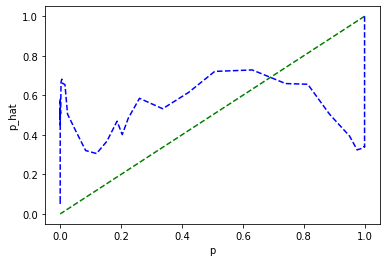

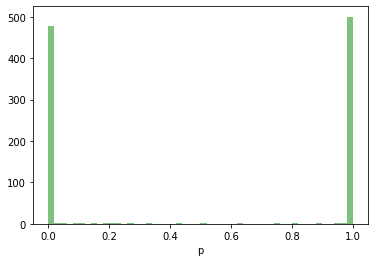

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

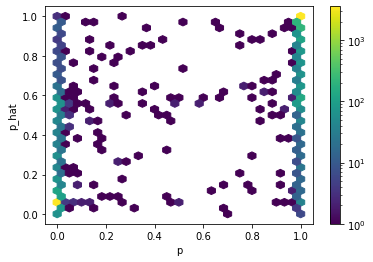

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

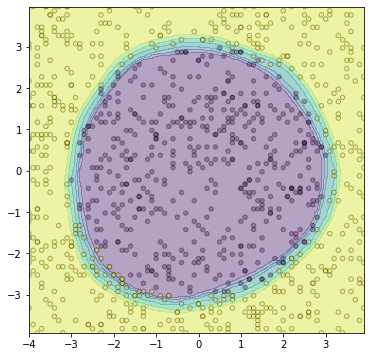

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = np.zeros((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 60)                660       
                                                                 
 dropout_72 (Dropout)        (None, 60)                0         
                                                                 
 dense_97 (Dense)            (None, 60)                3660      
                                                                 
 dropout_73 (Dropout)        (None, 60)                0         
                                                                 
 dense_98 (Dense)            (None, 60)                3660      
                                                                 
 dropout_74 (Dropout)        (None, 60)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.005,
 'batch': 8,
 'epoch': 3,
 'optimizer': 'rmsprop',
 'best_loss': {'loss': 0.16249872744083405, 'epoch': 5},
 'best_auc': {'auc': 0.9849624633789062, 'epoch': 5},
 'best_accuracy': {'accuracy': 0.9283499717712402, 'epoch': 3},
 'model': <keras.engine.sequential.Sequential at 0x7f3ba9cf13a0>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.25704121589660645, 'epoch': 118},
  'best_auc': {'auc': 0.9928462505340576, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.8988999724388123, 'epoch': 74}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.2397507280111313, 'epoch': 95},
  'best_auc': {'auc': 0.9937729835510254, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.9126499891281128, 'epoch': 40}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.2264856994152069, 'epoch': 68},
  'best_auc': {'auc': 0.9944378733634949, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.9172999858856201, 'epoch': 41}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 177,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.2048059105873108, 'epoch': 205},
  'best_auc': {'auc': 0.9955456852912903, 'epoch': 249},
  'best_a

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25